In [1]:
import datetime
import time

import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import pgpasslib

from QueryMSC import workflow_tools

In [2]:
connection_string = "postgresql+psycopg2://nannau@dbmsc.pcic.uvic.ca/msc"
engine = create_engine(connection_string)
Session = sessionmaker(bind=engine)
session = Session()

In [3]:
start_time = datetime.datetime(1990, 1, 1)
end_time = datetime.datetime(2000, 1, 1)

msc = workflow_tools(start_time, end_time, month=1)

In [4]:
#precip = msc.annual_rain()

In [5]:
#pd.read_sql(precip.statement, msc.engine).head()

In [6]:
#variables = msc.query_variables()

In [7]:
#pd.read_sql(variables.statement, msc.engine).head()

In [9]:
hdd = msc.deg_day_below_18_query(session)
print(hdd)

SELECT sum((%(param_1)s - crmp.obs_raw.datum * %(datum_1)s) / %(param_2)s) AS hdd, min(crmp.obs_raw.obs_time) AS min_date, max(crmp.obs_raw.obs_time) AS max_date, sum(EXTRACT(day FROM crmp.obs_raw.obs_time)) AS sum_1, crmp.meta_history.lat AS crmp_meta_history_lat, crmp.meta_history.lon AS crmp_meta_history_lon, crmp.meta_history.station_id AS crmp_meta_history_station_id 
FROM crmp.obs_raw JOIN crmp.meta_history ON crmp.meta_history.history_id = crmp.obs_raw.history_id JOIN crmp.meta_vars ON crmp.meta_vars.vars_id = crmp.obs_raw.vars_id 
WHERE %(datum_2)s - crmp.obs_raw.datum > %(param_3)s AND crmp.obs_raw.obs_time <= %(obs_time_1)s AND crmp.obs_raw.obs_time >= %(obs_time_2)s AND crmp.meta_vars.standard_name = %(standard_name_1)s AND crmp.meta_vars.vars_id = %(vars_id_1)s GROUP BY crmp.meta_history.lat, crmp.meta_history.lon, crmp.meta_history.station_id 
HAVING EXTRACT(year FROM max(crmp.obs_raw.obs_time)) - EXTRACT(year FROM min(crmp.obs_raw.obs_time)) >= %(param_4)s


In [11]:
start = time.time()
df = pd.read_sql(hdd.statement, engine)
end = time.time()
print((end-start)/60., 'minutes', (end-start), 'seconds')

0.6674595236778259 minutes 40.047571420669556 seconds


In [12]:
df.head()

,hdd,min_date,max_date,sum_1,lat,lon,station_id
0,3116.26,1990-01-01,2000-01-01,55525.0,50.3332,-125.4460,176
1,5399.89,1990-01-01,2000-01-01,46063.0,48.5697,-81.3767,5468
2,6623.72,1990-01-01,2000-01-01,48701.0,58.7667,-111.1170,3610
3,5687.91,1990-01-01,2000-01-01,43608.0,58.6214,-117.1650,3640
4,4587.14,1990-01-01,2000-01-01,51378.0,49.6316,-115.9620,1398


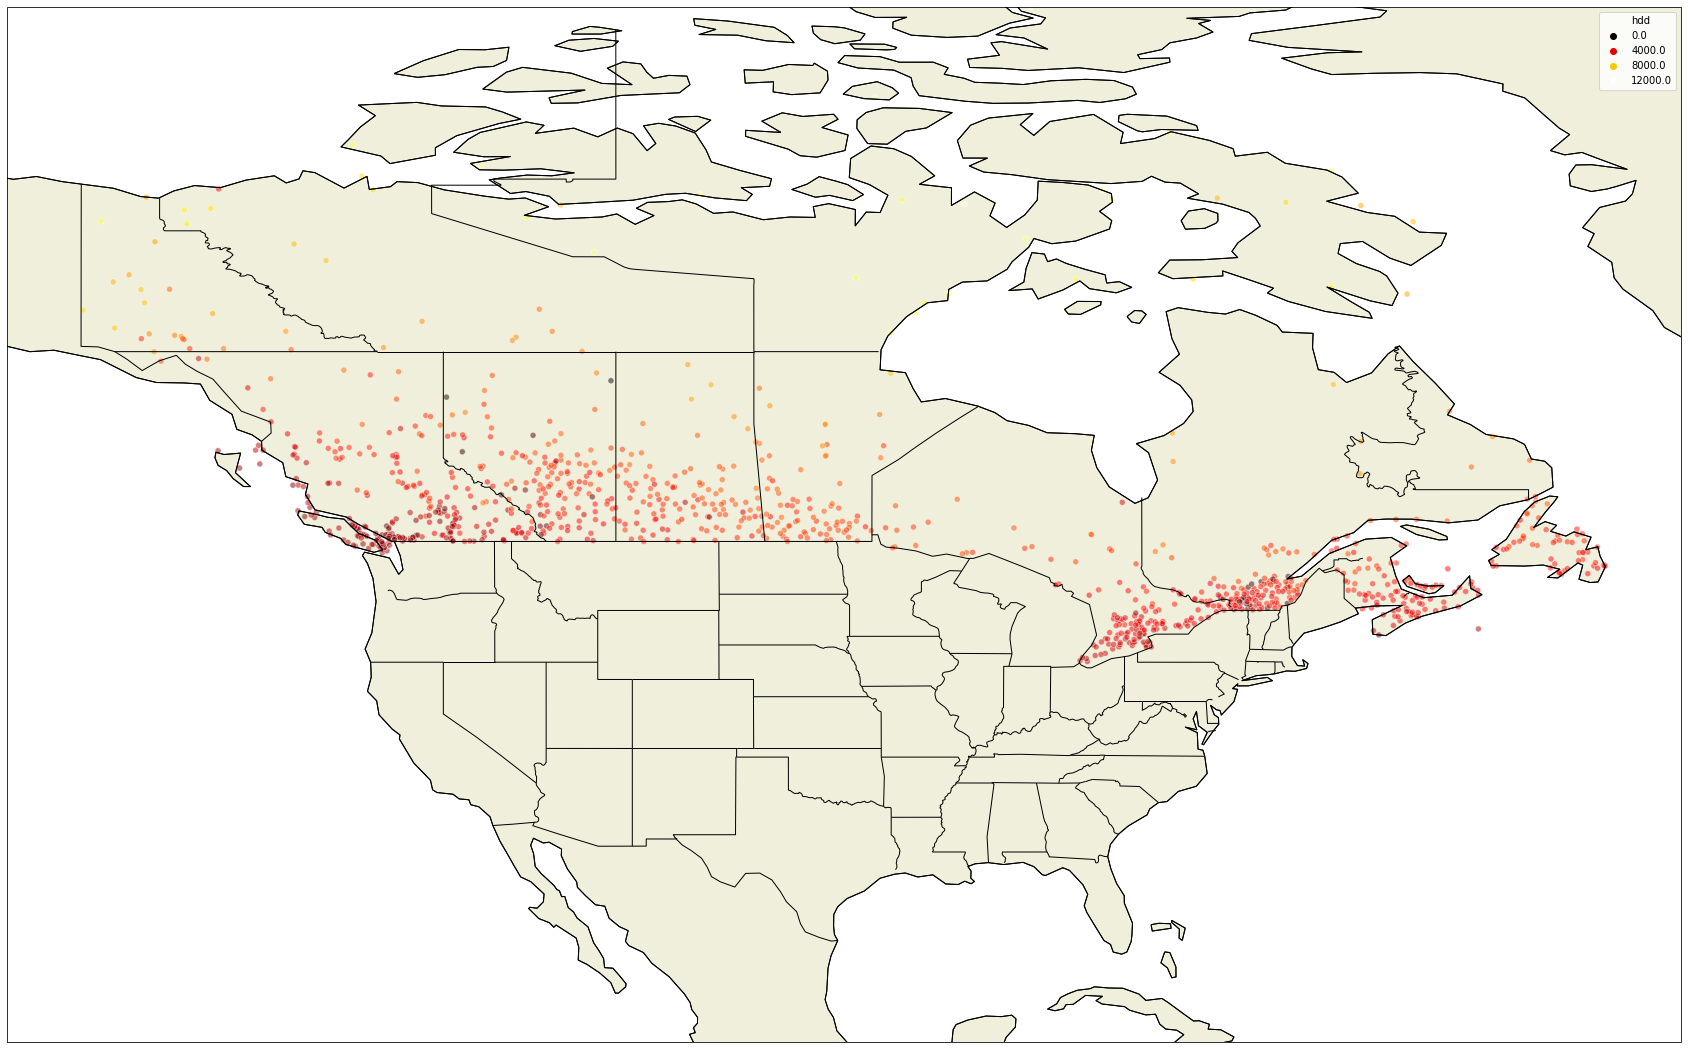

In [13]:
fig = plt.figure(figsize = (30, 50))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(states_provinces, edgecolor='black')

sns.scatterplot(df['lon'], df['lat'], hue=df['hdd'], palette="hot", alpha=0.5)
plt.ylim(20, 80)
plt.savefig('plots/spatial_25_jan')

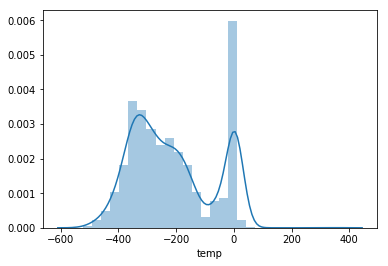

In [12]:
sns.distplot(df['temp'])